<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/autoencoder_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder image segmentation
This is an attempt to implement an idea to use autoencoders to encode local spatial information of images to then apply clustering.

In [51]:
import math
import numpy as np

In [52]:
from keras import Sequential, Input, Model
from keras.layers import Activation, Flatten, Dense, Reshape

## 1. Sliding window autoencoder

TODO: save parameters at each epoch and enable loading epochs from file.

In [96]:
class WindowAE:
  def __init__(self, window_size=(7, 7), num_channels=1, encoder_sizes=None,
               decoder_sizes=None):
    self.model = None
    self.encoder = None
    self._built = False
    self.max = 1.0
    self.min = 0.0
    self.window_size = window_size
    self.num_channels = num_channels
    self.encoder_sizes = encoder_sizes
    self.decoder_sizes = decoder_sizes
  
  def auto_decoder_sizes(self, encoder_sizes):
    self.encoder_sizes = encoder_sizes
    flat_size = self.window_size[0] * self.window_size[1] * self.num_channels
    self.decoder_sizes = (*encoder_sizes[-2::-1], flat_size)

  def make(self):
    if (
        not self._built and
        self.encoder_sizes is not None and
        self.decoder_sizes is not None
    ):
      stack_size = self.window_size + (self.num_channels+2,)
      input_window = Input(stack_size)

      x = Flatten()(input_window)
      for s in self.encoder_sizes:
        x = Dense(s, activation='relu')(x)
      
      encoded = Activation('linear')(x)

      for s in self.decoder_sizes:
        x = Dense(s, activation='relu')(x)
      
      decoded = Reshape(stack_size)(x)  # must match unraveled decoder_sizes[-1]

      self.model = Model(input_window, decoded)
      self.encoder = Model(input_window, encoded)
  
  def compile(self):
    self.model.compile(loss='mse', optimizer='adam', metrics=['mse'])
  
  def fit_transform(self, x):
    self.max = np.max(x)
    self.min = np.min(x)
  
  def transform_x(self, x):
    # Normalize.
    x_norm = (x - self.min) / (self.max - self.min)

    # Zero padding.
    pad = (*(math.floor(s/2) for s in self.window_size), 0)
    pad_widths = tuple((p, p) for p in pad)
    x_pad = np.pad(x_norm, pad_widths)

    # Stack array with positional information.
    pos_i = np.arange(-pad[0], x.shape[0]+pad[0], dtype='float')
    pos_j = np.arange(-pad[1], x.shape[1]+pad[1], dtype='float')
    x_i = np.outer(pos_i, np.ones(x_pad.shape[1], dtype='float'))
    x_j = np.outer(np.ones(x_pad.shape[0], dtype='float'), pos_j)
    x_full = np.dstack((x_pad, x_i, x_j))

    return x_full
  
  def transform_y(self, y):
    return self.transform_x(y)
  
  def encode(self, x):
    x_full = self.transform_x(x)
    enc_full = np.zeros((*x.shape[:2], self.encoder_sizes[-1]))

    for p in range(x.shape[0]*x.shape[1]):
      unravel_p = np.unravel_index(p, x.shape[:2])
      window = x_full[unravel_p[0]:unravel_p[0]+self.window_size[0],
                      unravel_p[1]:unravel_p[1]+self.window_size[1]]
      enc_p = self.encoder.predict(window)
      enc_full[unravel_p] = np.flatten(enc_p)
    
    return enc_full
  
  def predict(self, x):
    x_full = self.transform_x(x)
    pred = np.zeros_like(x)
    pad_half = tuple(math.floor(s/2) for s in self.window_size)

    for p in range(x.shape[0]*x.shape[1]):
      unravel_p = np.unravel_index(p, x.shape[:2])
      window = x_full[unravel_p[0]:unravel_p[0]+self.window_size[0],
                      unravel_p[1]:unravel_p[1]+self.window_size[1]]
      window = np.expand_dims(window, axis=0)
      pred_window = self.model.predict(window)

      # Store central pixel of pred_window in pred.
      pred[unravel_p] = pred_window[unravel_p[0]+pad_half[0],
                                    unravel_p[1]+pad_half[1]]
      
    return pred

  def fit(self, x, y, epochs=1, batch_size=32, **kwargs):
    x_full = self.transform_x(x)
    y_full = self.transform_y(y)

    history = []

    for ep in range(epochs):
      # Make a random choice of pixels.
      ravel_choice = np.random.choice(np.arange(x.shape[0]*x.shape[1]),
                                      batch_size, replace=False)
      unravel_choice = np.column_stack(np.unravel_index(ravel_choice,
                                                        x.shape[:2]))
      
      # Make windows for each pixel and stack them.
      # Central pixel is chosen pixel, but we don't have to shift start
      # indices.
      x_stack = np.stack(tuple(x_full[i:i+self.window_size[0],
                                      j:j+self.window_size[1]]
                               for i, j in unravel_choice), axis=0)
      y_stack = np.stack(tuple(y_full[i:i+self.window_size[0],
                                      j:j+self.window_size[1]]
                               for i, j in unravel_choice), axis=0)
      
      # Train network on stack.
      history.append(self.model.fit(x_stack, y_stack, epochs=ep+1,
                                    initial_epoch=ep, **kwargs))
    
    return history

## 2. GPWv411 Population Count dataset

In [34]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
!ls '/content/drive/My Drive/GoogleEarthEngine'

GPW_v411_pc_time0.tif  GPW_v411_pc_time2.tif  GPW_v411_pc_time4.tif
GPW_v411_pc_time1.tif  GPW_v411_pc_time3.tif


In [37]:
import rasterio

In [38]:
import numpy as np

In [39]:
with rasterio.open('/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time0.tif', 'r') as ds:
  time0 = ds.read()

gpw = np.zeros((time0.shape[1], time0.shape[2], 5), dtype='float')
gpw[..., 0] = time0[0]

for i in range(4):
  with rasterio.open(f'/content/drive/My Drive/GoogleEarthEngine/GPW_v411_pc_time{i+1}.tif', 'r') as ds:
    gpw[..., i+1] = ds.read()[0]

gpw[np.isnan(gpw)] = 0.0

In [40]:
!git clone https://github.com/olley102/CommunityDetectionURSS.git

Cloning into 'CommunityDetectionURSS'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 93 (delta 38), reused 47 (delta 12), pack-reused 0
Unpacking objects: 100% (93/93), done.


In [41]:
import sys
sys.path.append('/content/CommunityDetectionURSS')

In [42]:
from image_processing import optical_flow

In [43]:
uv = optical_flow.iteration(gpw, 1, alpha=10, use_previous=True, centering=(0, 0, 0))

In [44]:
image0 = np.dstack((gpw[..., 0], np.moveaxis(uv[..., 0], 0, -1)))

In [45]:
image0.shape

(1796, 1105, 3)

## 3. Apply WindowAE

In [113]:
ae = WindowAE(window_size=(7, 7), num_channels=3, encoder_sizes=(49, 3), decoder_sizes=(49, 245))

In [114]:
ae.make()
ae.compile()

In [115]:
ae.model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten_5 (Flatten)         (None, 245)               0         
                                                                 
 dense_20 (Dense)            (None, 49)                12054     
                                                                 
 dense_21 (Dense)            (None, 3)                 150       
                                                                 
 dense_22 (Dense)            (None, 49)                196       
                                                                 
 dense_23 (Dense)            (None, 245)               12250     
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 5)           0  

In [116]:
ae.encoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 7, 5)]         0         
                                                                 
 flatten_5 (Flatten)         (None, 245)               0         
                                                                 
 dense_20 (Dense)            (None, 49)                12054     
                                                                 
 dense_21 (Dense)            (None, 3)                 150       
                                                                 
 activation_5 (Activation)   (None, 3)                 0         
                                                                 
Total params: 12,204
Trainable params: 12,204
Non-trainable params: 0
_________________________________________________________________


In [117]:
image0.shape[0] * image0.shape[1]

1984580

In [118]:
history = ae.fit(image0, image0, epochs=2000, batch_size=1000)

32/32 [==============================] - 1s 3ms/step - loss: 187776.9688 - mse: 187776.9688
Epoch 2/2
32/32 [==============================] - 0s 2ms/step - loss: 106741.4219 - mse: 106741.4219
Epoch 3/3
32/32 [==============================] - 0s 3ms/step - loss: 91286.3828 - mse: 91286.4062
Epoch 4/4
32/32 [==============================] - 0s 3ms/step - loss: 94840.9297 - mse: 94840.9297
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 72138.1875 - mse: 72138.1797
Epoch 6/6
32/32 [==============================] - 0s 3ms/step - loss: 70486.0938 - mse: 70486.1094
Epoch 7/7
32/32 [==============================] - 0s 2ms/step - loss: 68993.9141 - mse: 68993.9141
Epoch 8/8
32/32 [==============================] - 0s 2ms/step - loss: 70250.5312 - mse: 70250.5312
Epoch 9/9
32/32 [==============================] - 0s 2ms/step - loss: 71037.9453 - mse: 71037.9297
Epoch 10/10
32/32 [==============================] - 0s 3ms/step - loss: 69427.1484 - mse: 69427.1641
Epoc

In [104]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'mse')

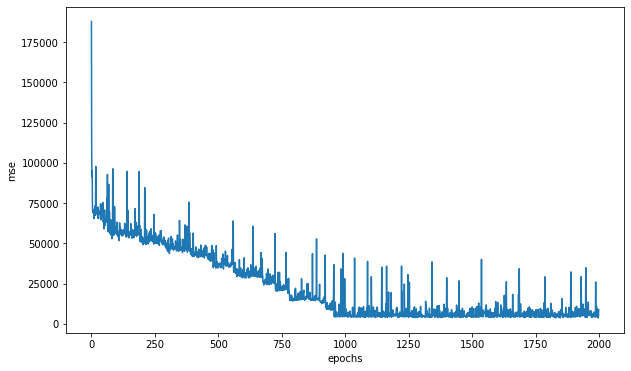

In [120]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
history_arr = [h.history['loss'][0] for h in history]
ax.plot(history_arr)
ax.set_xlabel('epochs')
ax.set_ylabel('mse')

Stagnation at about 1000 epochs.

In [121]:
np.argmin(history_arr[1000:1100])

59

In [123]:
np.min(history_arr[1000:1100])

4052.90625

In [124]:
history_arr[1059]

4052.90625

In [126]:
ae.predict(image0)

ValueError: ignored